# Part 2: Using the superpixels to segment the image

Getting the required libraries

In [4]:
!pip install pystruct
# !wget http://www.ais.uni-bonn.de/download/pascal_preprocessed/data_train.pickle
# !wget http://www.ais.uni-bonn.de/download/pascal_preprocessed/data_val.pickle
! pip install cvxopt
!pip install pyqpbo

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Importing the required libraries.

In [0]:
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import pickle

from pystruct import learners
import pystruct.models as crfs
from pystruct.utils import SaveLogger


Loading preprocessed *superpixels* (what Part 1 aimed to do) for the CRFs to work with.

In [0]:
data_train = pickle.load(open("data_train.pickle"))

In [0]:
C = 0.01 #Regularization parameter
n_states = 21 #

In [8]:
print("number of samples: %s" % len(data_train['X'])) # no. of samples being trained on
class_weights = 1. / np.bincount(np.hstack(data_train['Y']))
class_weights *= 21. / np.sum(class_weights)
print(class_weights) # showing normalized class weights

number of samples: 964
[0.01347196 1.20156934 3.20418491 1.03334963 1.20859606 1.37779951
 0.57249287 0.57249287 0.37817004 0.93515804 1.375507   0.77695461
 0.67594416 1.01184787 0.87572003 0.23247461 1.75515861 1.03205956
 0.96125547 0.7964159  1.00937693]


Initializing CRF model imported from pystruct library. This will unary and binary potentials among the superpixels which are then used to segment the image.

In [0]:
model = crfs.EdgeFeatureGraphCRF(inference_method='qpbo',
                                 class_weight=class_weights,
                                 symmetric_edge_features=[0, 1],
                                 antisymmetric_edge_features=[2])

Defining NSlackSSVM model which helps in training the earlier defined model. And then fitting the model.

In [10]:
experiment_name = "edge_features_one_slack_trainval_%f" % C

ssvm = learners.NSlackSSVM(
    model, verbose=1, C=C, max_iter=10, n_jobs=-1,
    tol=0.0001, show_loss_every=5,
    logger=SaveLogger(experiment_name + ".pickle", save_every=100),
    inactive_threshold=1e-3, inactive_window=30, batch_size=100)
ssvm.fit(data_train['X'], data_train['Y'])

Training n-slack dual structural SVM
iteration 0
current loss: 0.948721
new constraints: 963, cutting plane objective: 12.337357 primal objective: 578.089422
iteration 1
new constraints: 963, cutting plane objective: 36.573195 primal objective: 388.502989
iteration 2
new constraints: 954, cutting plane objective: 61.341926 primal objective: 199.386270
iteration 3
new constraints: 951, cutting plane objective: 77.573769 primal objective: 116.350929
iteration 4
bad inference: 1.655291
bad inference: 0.040099
bad inference: 0.414510
bad inference: 0.154147
bad inference: 0.049059
bad inference: 0.352618
bad inference: 0.908626
bad inference: 0.814310
new constraints: 935, cutting plane objective: 84.514264 primal objective: 100.349568
iteration 5
bad inference: 0.467140
bad inference: 0.255489
bad inference: 0.221841
bad inference: 0.598087
bad inference: 0.047609
bad inference: 0.233754
bad inference: 0.205466
bad inference: 1.179423
bad inference: 0.111505
bad inference: 0.128087
bad in

bad inference: 0.441591
bad inference: 0.286285
bad inference: 0.214117
bad inference: 0.184488
bad inference: 0.017628
bad inference: 0.004894
bad inference: 0.024715
bad inference: 0.006568
bad inference: 0.000018
bad inference: 0.000589
bad inference: 0.000679
bad inference: 0.454001
bad inference: 0.004505
bad inference: 0.105290
bad inference: 0.011436
bad inference: 0.057765
bad inference: 0.053942
bad inference: 0.018510
bad inference: 0.000634
bad inference: 0.113916
bad inference: 0.000533
bad inference: 0.002672
bad inference: 0.000692
bad inference: 0.057910
bad inference: 0.013066
bad inference: 0.165534
bad inference: 0.030370
bad inference: 0.538354
bad inference: 0.001053
bad inference: 0.137525
bad inference: 0.029564
bad inference: 0.066532
bad inference: 0.109555
bad inference: 0.108303
bad inference: 0.012343
bad inference: 0.026554
bad inference: 0.163206
bad inference: 0.028484
bad inference: 0.168253
bad inference: 1.275105
bad inference: 0.960732
bad inference: 0

NSlackSSVM(C=0.01, batch_size=100, break_on_bad=False, check_constraints=True,
      inactive_threshold=0.001, inactive_window=30,
      logger=SaveLogger(file_name="edge_features_one_slack_trainval_0.010000.pickle", save_every=100),
      max_iter=10,
      model=EdgeFeatureGraphCRF(n_states: 21, inference_method: qpbo, n_features: 21, n_edge_features: 3),
      n_jobs=-1, negativity_constraint=None, show_loss_every=5,
      switch_to=None, tol=0.0001, verbose=1)

Loading validation dataset(superpixels). Calculating the score of the model. Please keep in mind that we have only partially trained the model due to constraints.

In [11]:
data_val = pickle.load(open("data_val.pickle"))
y_pred = ssvm.predict(data_val['X'])
temp = y_pred
# we throw away void superpixels and flatten everything
y_pred, y_true = np.hstack(y_pred), np.hstack(data_val['Y'])
y_pred = y_pred[y_true != 255]
y_true = y_true[y_true != 255]

print("Score on validation set: %f" % np.mean(y_true == y_pred))


Score on validation set: 0.773596


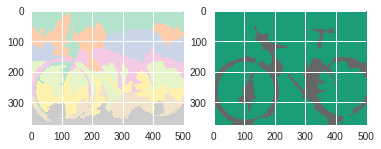

2007_006449
209


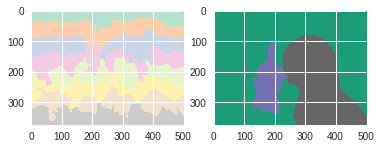

2007_000346
9


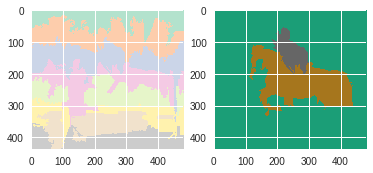

2007_000783
23


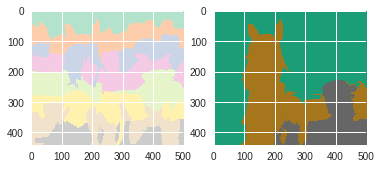

2007_000799
24


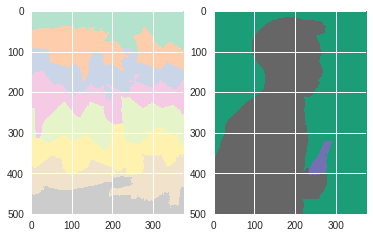

2007_000999
31


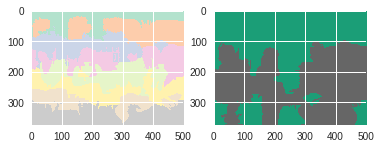

2007_001284
35


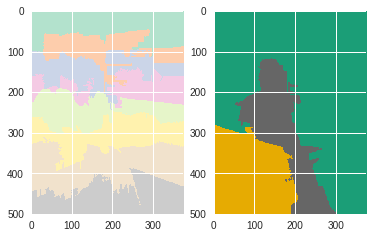

2007_000847
28


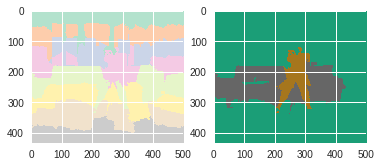

2007_001585
49


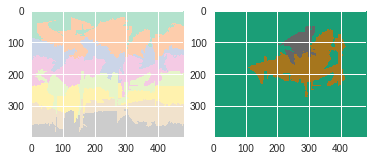

2007_001586
50


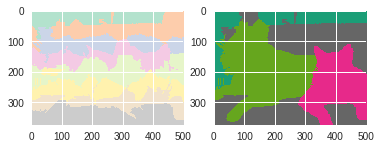

2007_001763
59


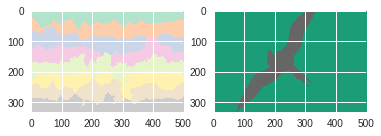

2007_002094
64


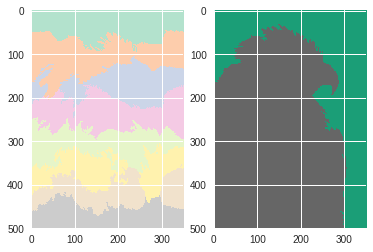

2007_002400
74


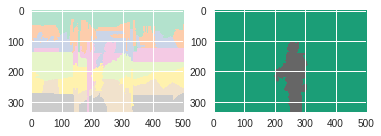

2007_002539
80


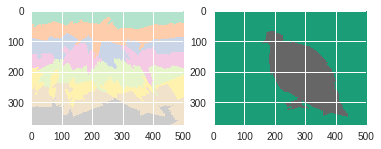

2007_004143
138


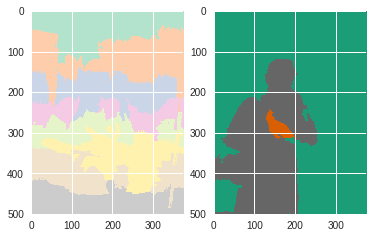

2007_006076
198


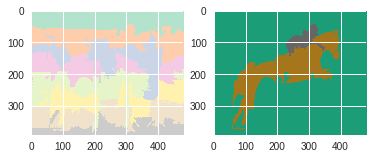

2007_006866
222


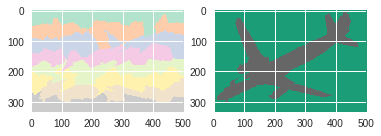

2007_006946
223


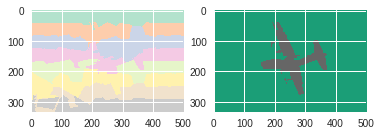

2007_007470
238


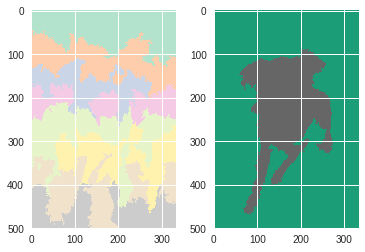

2007_008222
261


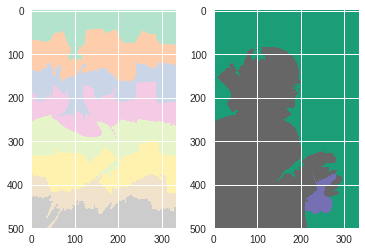

2007_009654
305


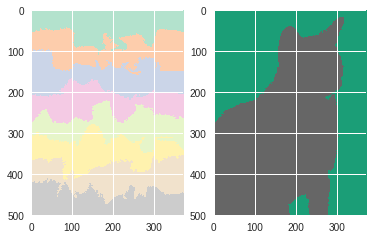

2007_009794
314


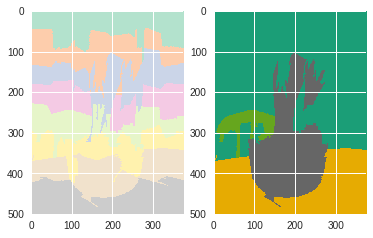

2008_002379
404


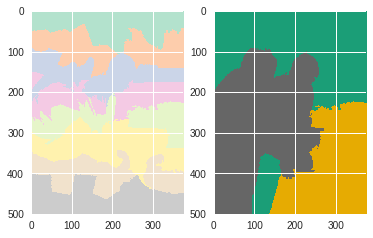

2008_004140
438


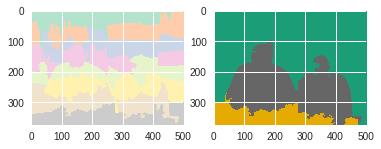

2008_006108
485


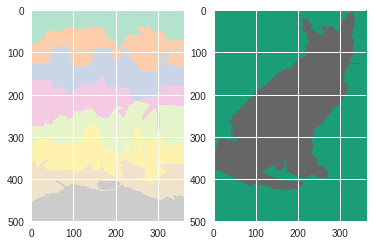

2010_000163
757


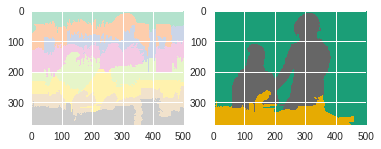

2010_000174
758


In [12]:
%matplotlib inline
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, show
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import OrderedDict
cmaps = OrderedDict()
for i in [209, 9, 23, 24, 31, 35, 28, 49, 50, 59, 64, 74, 80, 138, 198,  222, 223, 238, 261, 305, 314, 404, 438, 485, 757, 758]:  
  plt.subplot(1, 2, 1)
  imshow(data_val['superpixels'][i], cmap='Pastel2')
  img2 = np.zeros(data_val['superpixels'][i].shape)
  for a in range(data_val['superpixels'][i].shape[0]):
    for b in range(data_val['superpixels'][i].shape[1]):
      img2[a,b] = data_val['Y'][i][data_val['superpixels'][i][a,b]]
  plt.subplot(1, 2, 2)
  imshow(img2, cmap='Dark2',)
  show()
#   print(data_val['Y'][i])
  print(data_val['file_names'][i])
  print (i)


Here the first images are the superpixel inputs we gave to the CRF to segment. The CRF after calculating unary and pairwaise potentials predicted the segmentation of the image. You can see in the second image that the CRF is successfully able to detect objects in the image.

Due to the consistency in the segmentation we can come to the conlusion that the model has successfully learned to segment given the superpixels. The superpixels are calculated using traiditional methods described in **Part 1**